In [1]:
#data source https://archive.ics.uci.edu/dataset/601/ai4i+2020+predictive+maintenance+dataset

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.feature_selection import mutual_info_classif

In [3]:
file_path = "/Users/jengjava/Desktop/my-new-repo/ml-fp/data/raw/predictive_maintenance.csv"

In [4]:
df = pd.read_csv(file_path)
df = df.copy()
df.head(5)

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [5]:
print(df.dtypes)

UDI                          int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Target                       int64
Failure Type                object
dtype: object


In [6]:
# Cell: Define Data Columns
categorical_cols = ["Type", "Product ID", "Failure Type"]
numerical_cols = [
    "Air temperature [K]",
    "Process temperature [K]",
    "Rotational speed [rpm]",
    "Torque [Nm]",
    "Tool wear [min]"
]


In [7]:
def define_data_columns():
    categorical_cols = ["Type", "Product ID", "Failure Type"]

    numerical_cols = [
    "Air temperature [K]",
    "Process temperature [K]",
    "Rotational speed [rpm]",
    "Torque [Nm]",
    "Tool wear [min]",
]
    return categorical_cols, numerical_cols

cat_cols, num_cols = define_data_columns()
print("Categorical Columns:", cat_cols)
print("Numerical Columns:", num_cols)

Categorical Columns: ['Type', 'Product ID', 'Failure Type']
Numerical Columns: ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']


In [8]:
# label enconding
le_dict = {}

for col in cat_cols:
    le = LabelEncoder()
    df[col + "_encoded"] = le.fit_transform(df[col])
    le_dict[col] = le

print("encoded columns:")
print (df[[col + "_encoded" for col in cat_cols]].head(5))

encoded columns:
   Type_encoded  Product ID_encoded  Failure Type_encoded
0             2                7003                     1
1             1                1003                     1
2             1                1004                     1
3             1                1005                     1
4             1                1006                     1


In [9]:
feature_cols = numerical_cols + [col + "_encoded" for col in categorical_cols]
features_array = df[feature_cols].values
features_array

array([[2.981e+02, 3.086e+02, 1.551e+03, ..., 2.000e+00, 7.003e+03,
        1.000e+00],
       [2.982e+02, 3.087e+02, 1.408e+03, ..., 1.000e+00, 1.003e+03,
        1.000e+00],
       [2.981e+02, 3.085e+02, 1.498e+03, ..., 1.000e+00, 1.004e+03,
        1.000e+00],
       ...,
       [2.990e+02, 3.086e+02, 1.645e+03, ..., 2.000e+00, 9.998e+03,
        1.000e+00],
       [2.990e+02, 3.087e+02, 1.408e+03, ..., 0.000e+00, 1.002e+03,
        1.000e+00],
       [2.990e+02, 3.087e+02, 1.500e+03, ..., 2.000e+00, 9.999e+03,
        1.000e+00]], shape=(10000, 8))

In [10]:
y_binary = df["Target"].values
y_multiclass = df["Failure Type_encoded"].values

mi_scores = mutual_info_classif(features_array, y_binary)

feature_importance = pd.DataFrame({
    "feature": feature_cols,
    "mi_scores": mi_scores
})

feature_importance = feature_importance.sort_values(by="mi_scores", ascending=False)

print("Feature Importance:")
print(feature_importance)

Feature Importance:
                   feature  mi_scores
7     Failure Type_encoded   0.143028
3              Torque [Nm]   0.046260
2   Rotational speed [rpm]   0.038036
6       Product ID_encoded   0.012255
4          Tool wear [min]   0.012122
0      Air temperature [K]   0.006641
5             Type_encoded   0.001925
1  Process temperature [K]   0.001577


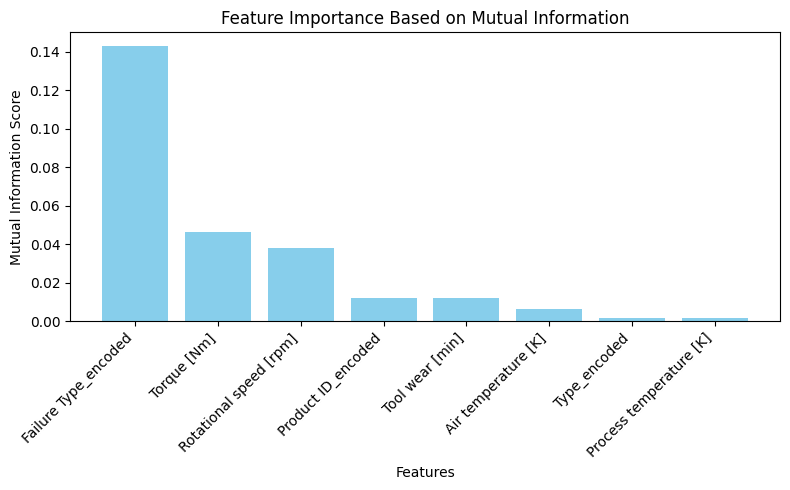

In [11]:
import matplotlib.pyplot as plt

# Plot the mutual information scores as a bar chart
plt.figure(figsize=(8, 5))
plt.bar(feature_importance["feature"], feature_importance["mi_scores"], color="skyblue")
plt.xlabel("Features")
plt.ylabel("Mutual Information Score")
plt.title("Feature Importance Based on Mutual Information")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [12]:
threshold = mi_scores.mean()

selected_features = feature_importance[feature_importance["mi_scores"] > threshold]["feature"].tolist()
X = df[selected_features].values


# Display the selected features and the shape of the resulting feature matrix.
print("Selected Features:", selected_features)
print("Feature matrix shape:", X.shape)
X

Selected Features: ['Failure Type_encoded', 'Torque [Nm]', 'Rotational speed [rpm]']
Feature matrix shape: (10000, 3)


array([[1.000e+00, 4.280e+01, 1.551e+03],
       [1.000e+00, 4.630e+01, 1.408e+03],
       [1.000e+00, 4.940e+01, 1.498e+03],
       ...,
       [1.000e+00, 3.340e+01, 1.645e+03],
       [1.000e+00, 4.850e+01, 1.408e+03],
       [1.000e+00, 4.020e+01, 1.500e+03]], shape=(10000, 3))

In [ ]:
import requests

# FastAPI server URL
FASTAPI_URL = "http://localhost:8000/predict"

# Define the input data
# In order of the features: UDI, Air temperature (K), Process temperature (K), Rotational speed (rpm), Torque (Nm), Tool wear (min), Type encoded, Product ID encoded, Failure Type encoded
# Ensure to adjust the data based on actual possible inputs and features expected by the model
payload = {
    "features": [
        2,          # UDI
        310.5,      # Air temperature in Kelvin
        320.1,      # Process temperature in Kelvin
        2000,       # Rotational speed in rpm
        50.5,       # Torque in Nm
        10,         # Tool wear in minutes
        1,          # Type encoded (categorical, numeric encoding)
        8005,       # Product ID encoded (categorical, numeric encoding)
        0           # Failure Type encoded (target variable, if used for retraining or similar scenarios)
    ]
}

# Send request to FastAPI
response = requests.post(FASTAPI_URL, json=payload)

# Handle response
if response.status_code == 200:
    print("Prediction:", response.json())  # Print the predicted output, likely a machine failure prediction or similar
else:
    print("Error:", response.status_code, response.text)  # Handle errors like 404 or 500 from server


===== Prediction Response =====
Status Code: 200
Showing first 20 of 1000 predictions:
  Row 1: 0
  Row 2: 0
  Row 3: 1
  Row 4: 0
  Row 5: 0
  Row 6: 0
  Row 7: 0
  Row 8: 1
  Row 9: 1
  Row 10: 0
  Row 11: 1
  Row 12: 0
  Row 13: 0
  Row 14: 0
  Row 15: 1
  Row 16: 0
  Row 17: 1
  Row 18: 1
  Row 19: 0
  Row 20: 1



for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    # Split the data into training and validation sets
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y_binary[train_idx], y_binary[val_idx]
    y_train_multi, y_val_multi = y_multiclass[train_idx], y_multiclass[val_idx]

    # --- Binary Classification Model ---
    binary_model = XGBClassifier(random_state=42, eval_metric="logloss")
    binary_model.fit(X_train, y_train)
    binary_pred = binary_model.predict(X_val)
    fold_f1 = f1_score(y_val, binary_pred)
    f1_scores.append(fold_f1)
    print(f"Fold {fold + 1} - Binary F1 Score: {fold_f1:.4f}")
    binary_predictions[val_idx] = binary_pred

# Insert explanation

In [15]:
# ---------------------------------------------------
# Step 8: Create Submission DataFrame
# ---------------------------------------------------

# Create the submission DataFrame using:
# - "UDI": Unique identifiers from the original dataset.
# - "Target": Binary predictions (converted to integers).
# - "Failure_Type": Multiclass predictions are inverse-transformed back to original labels.
submission = pd.DataFrame({
    "UDI": df["UDI"],
    "Target": binary_predictions.astype(int),
    "Failure_Type": le_dict["Failure Type"].inverse_transform(multiclass_predictions.astype(int))
})

# Display the first few rows of the submission DataFrame
print("Submission preview:")
print(submission.head())


Submission preview:
   UDI  Target Failure_Type
0    1       0   No Failure
1    2       0   No Failure
2    3       0   No Failure
3    4       0   No Failure
4    5       0   No Failure


In [ ]:
import requests

# FastAPI server URL for the /model endpoint
FASTAPI_URL = "http://localhost:8000/model"

# Send request to the FastAPI model server to retrieve model metadata
response = requests.get(FASTAPI_URL)

# Handle the response from the server
if response.status_code == 200:
    model_info = response.json()  # Parse the JSON response containing the model details
    print("Model Information:")
    print("Input Schema:", model_info.get("input_schema", "No input schema information found"))
    print("Hyperparameters:", model_info.get("hyperparameters", "No hyperparameters information found"))
    print("Important Features:", model_info.get("important_features", "No important features information found"))
else:
    print("Error:", response.status_code, response.text)  # Print any errors encountered during the request

#### Insights on Retrieved Model Information

# Insert insights

<h2 style="color:#ffffff; background-color:#004aac; padding: 10px; text-align:left; border: 1px solid #004aac;">F. Drift Detection Demonstration</h2>

<h2 style="color:#d7633a; padding: 5px; text-align:left; border: 1px solid #d7633a;">Accessing Evidently AI from MLflow to Generate Drift Reports</h2>

Once the `drift_reports` asset is activated within **Dagster UI**, these reports are subsequently recorded in **MLflow**, specifically under Experiments → Artifacts.

**How to Access Drift Reports in MLflow**

1. Launch the **MLflow UI** by visiting http://localhost:5000.
2. Proceed to **Experiments** and select the **Most Recent Run**.
3. Navigate to the **Artifacts** tab.
4. Find and download the `drift_report.html` to examine the comprehensive drift analysis.

<h2 style="color:#d7633a; padding: 5px; text-align:left; border: 1px solid #d7633a;">Drift Result Analysis</h2>

# Insert analysis

<h2 style="color:#ffffff; background-color:#004aac; padding: 10px; text-align:left; border: 1px solid #004aac;">F. Reproducibility</h2>

This pipeline is designed to be fully reproducible to facilitate reliable and consistent results in machine learning model development, testing, and deployment processes.

#### **Steps to Ensure Reproducibility**

1. **Running Services:** Make sure that FastAPI and MLflow services are active. These are essential for handling API requests and tracking experiments, respectively.

    ```plaintext
    FastAPI should be accessible at: http://localhost:8000
    MLflow should be accessible at: http://localhost:5000
    ```

2. **Model Artifacts and Logs:** Confirm that the latest model artifacts and corresponding logs are properly generated and accessible in MLflow. This ensures that the models being deployed and tested are the latest iterations.

3.  **Configuration and Environment Variables:** Check that all environment variables and configurations are set correctly. This includes database URIs, API keys, and other service-specific configurations that might affect the system's behavior.

<h2 style="color:#ffffff; background-color:#004aac; padding: 10px; text-align:left; border: 1px solid #004aac;">G. References</h2>

[1] [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/601/ai4i+2020+predictive+maintenance+dataset)

[2] [Dagster Documentation](https://docs.dagster.io/)

[3] [MLflow Documentation](https://www.mlflow.org/docs/2.1.1/index.html?utm_source=google&utm_medium=cpc&utm_term=&utm_campaign=&gad_source=1&gclid=CjwKCAjwp8--BhBREiwAj7og1-SMU90CS2ghrTsi-kHfz67v2JAaQR5QQfRzhIKUK8VywBypvMULGxoCqhoQAvD_BwE)

[4] [FastAPI Documentation](https://fastapi.tiangolo.com/)

[5] [Docker Documentation](https://docs.docker.com/)

[6] [Evidently AI Documentation](https://docs.evidentlyai.com/introduction)